In [31]:
# Lets Install patchify package to make smaller imgages
! pip install patchify
! pip install tifffile
! pip install opencv-python
! pip install Pillow

### Electron Microscopic Image Dataset

The data can be download from https://www.epfl.ch/labs/cvlab/data/data-em/

The whole data is a 3D tiff image with 1065x2048x1536 volume where each voxel is approximately 5x5x5nm

Lets Download the traing and testing files (including the ground-truth) from the source first

In [26]:
!curl -o training.tif -k https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
!curl -o testing.tif -k https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif
!curl -o training_groundtruth.tif -k https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
!curl -o testing_groundtruth.tif -k https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif

### Creating small patches 
First we split the images into smaller patches using patchify

In [1]:
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from Utils import Create_Small_Patches
from Models import unet_model,unet_model_with_jacard
import tifffile as tiff
from tensorflow.keras.utils import normalize
from sklearn.model_selection import train_test_split
# Importing OpenCV and Pillow for Image Procsessing Purposes
import cv2 # OpenCV
from PIL import Image # Pillow

In [7]:
# Creating train/test folders for both Image and Mask data
if not os.path.isdir('Data'):
    os.mkdir('Data'); os.mkdir('Data/Training');  os.mkdir('Data/Testing');
    os.mkdir('Data/Training/Images'); os.mkdir('Data/Training/Masks'); 
    os.mkdir('Data/Testing/Images'); os.mkdir('Data/Testing/Masks'); 

In [8]:
# Reading train/test images and masks
training_image_stack = tiff.imread('training.tif')
training_mask_stack = tiff.imread('training_groundtruth.tif')
test_image_stack = tiff.imread('testing.tif')
test_mask_stack = tiff.imread('testing_groundtruth.tif')

We create 256x256 patches using the patchify package

In [9]:
Create_Small_Patches(training_image_stack,'Data/Training/Images/')
Create_Small_Patches(training_mask_stack,'Data/Training/Masks/')
Create_Small_Patches(test_image_stack,'Data/Testing/Images/')
Create_Small_Patches(test_mask_stack,'Data/Testing/Masks/')

In [10]:
training_image_directory = 'Data/Training/Images/'
training_mask_directory = 'Data/Training/Masks/'
testing_image_directory = 'Data/Testing/Images/'
testing_mask_directory = 'Data/Testing/Masks/'

In [11]:
# Creating Training Image and Mask Data set
SIZE = 256
training_image_dataset = []  
training_mask_dataset = []  

training_images = os.listdir(training_image_directory)
for i, image_name in enumerate(training_images):    
    if (image_name.split('.')[1] == 'tif'):
        
        image = cv2.imread(training_image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        training_image_dataset.append(np.array(image))
training_masks = os.listdir(training_mask_directory)
for i, image_name in enumerate(training_masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(training_mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        training_mask_dataset.append(np.array(image))

In [51]:
# Creating Testing Image and Mask Data set
SIZE = 256
testing_image_dataset = []  
testing_mask_dataset = []  

testing_images = os.listdir(testing_image_directory)
for i, image_name in enumerate(testing_images):    
    if (image_name.split('.')[1] == 'tif'):
        
        image = cv2.imread(testing_image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        testing_image_dataset.append(np.array(image))
        
testing_masks = os.listdir(testing_mask_directory)
for i, image_name in enumerate(testing_masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(testing_mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        testing_mask_dataset.append(np.array(image))

In [53]:
#Normalize Training/Testing Images
X = np.expand_dims(normalize(np.array(training_image_dataset), axis=1),3)
X_test = np.expand_dims(normalize(np.array(testing_image_dataset), axis=1),3)
#Re-scaling Training/Testing Masks to 0/1
y = np.expand_dims((np.array(training_mask_dataset)),3) /255.
y_test = np.expand_dims((np.array(testing_mask_dataset)),3) /255.

In [54]:
# Splitting data to train/dev set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10, random_state = 0)


### Plotting Image/Mask Samples
Plottinhg several images and masks

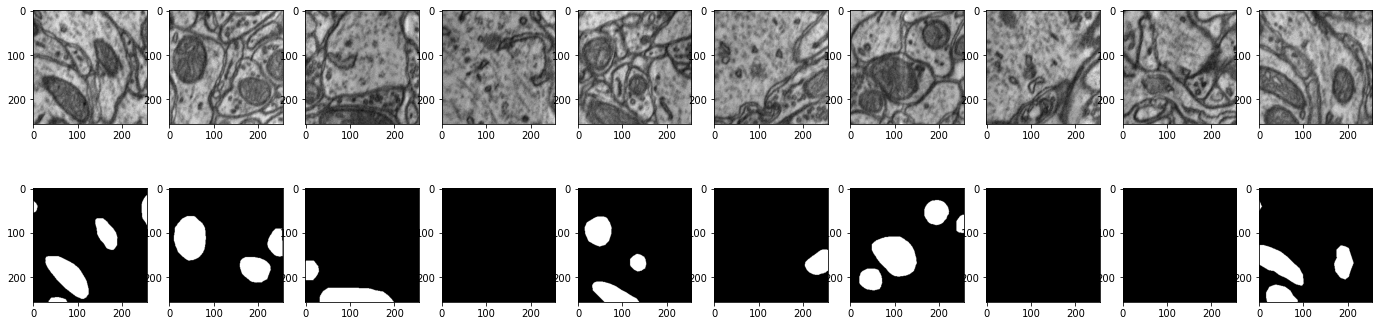

In [15]:
image_numbers = np.random.randint(0, len(X_train),size=10)
fig, ax = plt.subplots(2,10,figsize=(24, 6))
for i, num in enumerate(image_numbers):
    
    ax[0,i].imshow(np.reshape(X_train[num], (256, 256)), cmap='gray')
    ax[1,i].imshow(np.reshape(y_train[num], (256, 256)), cmap='gray')

In [17]:
IMG_HEIGHT = training_image_dataset.shape[1]
IMG_WIDTH  = training_image_dataset.shape[2]
IMG_CHANNELS = training_image_dataset.shape[3]

### Loading the Model
First we try a vanilla Unet Model

In [18]:
def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [20]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, y_val), 
                    shuffle=False)

model.save('EM_UNET_Model_100epochs.hdf5')

Epoch 1/100
112/112 [==============================] - 269s 2s/step - loss: 0.2270 - accuracy: 0.9296 - val_loss: 0.4619 - val_accuracy: 0.9400
Epoch 2/100
112/112 [==============================] - 274s 2s/step - loss: 0.1089 - accuracy: 0.9485 - val_loss: 0.2125 - val_accuracy: 0.9226
Epoch 3/100
112/112 [==============================] - 274s 2s/step - loss: 0.0561 - accuracy: 0.9782 - val_loss: 0.1002 - val_accuracy: 0.9591
Epoch 4/100
112/112 [==============================] - 269s 2s/step - loss: 0.0337 - accuracy: 0.9868 - val_loss: 0.0560 - val_accuracy: 0.9778
Epoch 5/100
112/112 [==============================] - 267s 2s/step - loss: 0.0260 - accuracy: 0.9899 - val_loss: 0.0280 - val_accuracy: 0.9895
Epoch 6/100
112/112 [==============================] - 276s 2s/step - loss: 0.0189 - accuracy: 0.9926 - val_loss: 0.0450 - val_accuracy: 0.9832
Epoch 7/100
112/112 [==============================] - 293s 3s/step - loss: 0.0181 - accuracy: 0.9929 - val_loss: 0.0332 - val_accuracy:

In [55]:
#Evaluate the model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

62/62 [==============================] - 47s 758ms/step - loss: 0.1076 - accuracy: 0.9822
Accuracy =  98.22361469268799 %


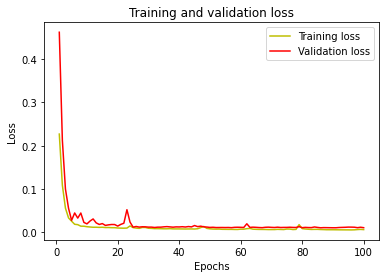

In [56]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

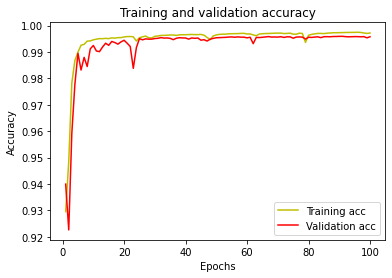

In [57]:
# acc = history.history['acc']
acc = history.history['accuracy']
# val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [79]:
#Calculating IOU (Intersection over Union)
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6964164618360489


In [77]:
# Loading and Testing the Model
model = get_model()
model.load_weights('EM_UNET_Model_100epochs.hdf5') 


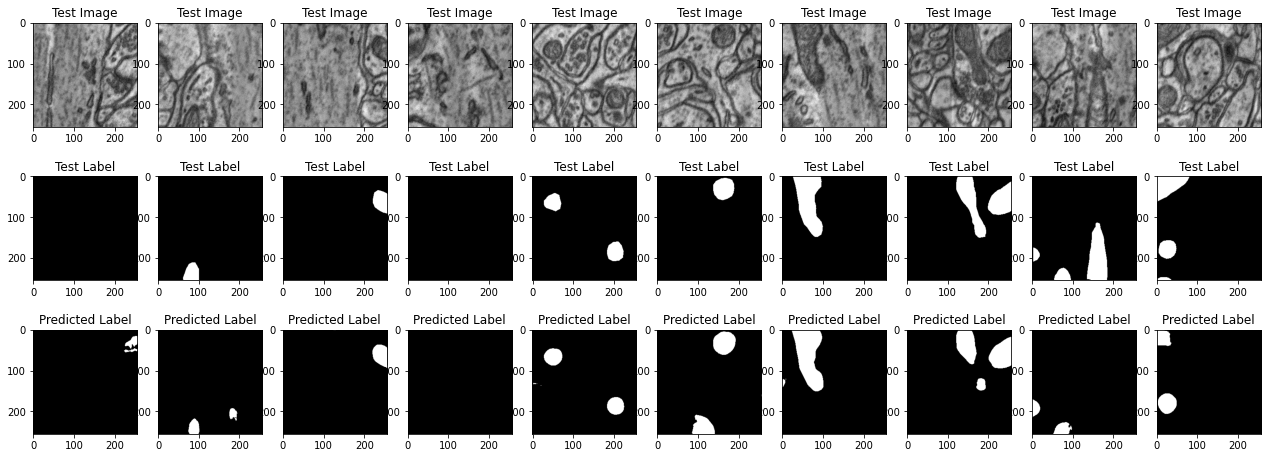

In [76]:
test_img_number = np.random.randint(0, len(X_test),10)
fig, ax = plt.subplots(3,10,figsize=(22,8))
for i,img_num in enumerate(test_img_number):
    test_img = X_test[img_num]
    ground_truth=y_test[img_num]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)
    ax[0,i].imshow(test_img[:,:,0], cmap='gray')
    ax[0,i].set_title('Test Image')
    ax[1,i].imshow(ground_truth[:,:,0], cmap='gray')
    ax[1,i].set_title('Test Label')
    ax[2,i].imshow(prediction, cmap='gray')
    ax[2,i].set_title('Predicted Label')